# Intro to Cython

Python is not the fastest. Everything is an object and all of them are implemented as a dictionary. Numpy's vectorized matrix operations can speed up a lot of things. Especially for-loops should not be written. But in the case when they can't be avoided (for example convolutional filters) the Cython package comes in handy.

The following snippets show how Cython works and compare the runtime of python code and cython code.

I am going to use the jupyter notebook extension for this post: [ipython cython docs](https://ipython.org/ipython-doc/2/config/extensions/cythonmagic.html).

In [25]:
%matplotlib inline

#Install cython
# !python -m pip install Cython

In [14]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [17]:
%%cython

# Write the same function twice: once for python and the other time for cython
# 
# Let's build functions to find prime numbers

# cimport includes the Numpy header files in order to access the numpy array declaration
# there would have also been the python array implementation
cimport numpy as np
# this is just the regular numpy python module
import numpy as np

# cdef declares a c function body whereis a normal def has to be wrapped
def get_primes_cython(int n):
    
    # a cdef block does all of the magic!
    # => this is the only real difference
    cdef:
        np.ndarray[np.int32_t, ndim=1] primes = np.zeros(n, dtype=np.int32)
        int i = 0;
        int last_prime = 2;
        int candidate = 1;
        int is_ok = 1;
    
    # collect n primes
    while (i<n):
        candidate += 1;
        is_ok = 1;
        
        # check if candidate is divisable by any number in old primes
        for c in range(i):
            # check
            if candidate % primes[c] == 0:
                is_ok = 0;
                break;

        # candidate was not divisable
        if is_ok == 1:
            primes[i] = candidate;
            i += 1;
    
    return primes;

# python implementation
def get_primes_python(n, use_numpy_array=False):
    
    # use numpy array or normal list
    if use_numpy_array:
        primes = np.zeros(n, dtype=np.int)
    else:
        primes = [0]*n
        
    # we use normal python variables here -> all of them are some kind of wrapped objects
    i = 0
    last_prime = 2
    candidate = 1
    is_ok = 1
    
    while i<n:
        candidate += 1
        is_ok = 1
        
        # check if candidate is divisable by any number in old primes
        for c in range(i):
            # check
            if candidate % primes[c] == 0:
                is_ok = 0;
                break;
            
        
        
        # candidate was not divisable
        if is_ok == 1:
            primes[i] = candidate;
            i += 1;
            
    return primes

# draw a sampe
print('Python list')
print(get_primes_python(10))
print('')
print('Python numpy')
print(get_primes_python(10, use_numpy_array=True))
print('')
print('Cython')
print(get_primes_cython(10))
print('')

Python list
[2, 3, 5, 7, 11, 13, 17, 19, 23, 29]

Python numpy
[ 2  3  5  7 11 13 17 19 23 29]

Cython
[ 2  3  5  7 11 13 17 19 23 29]



In [18]:
# are the results equal?
not_equal_elements = np.asarray(get_primes_cython(100) != get_primes_python(100), dtype=np.int)
sum_not_eq_elems = np.sum(not_equal_elements)

print('Number of different primes: {}'.format(sum_not_eq_elems))

Number of different primes: 0


## Timings

Now that we have the three possible combinations (cython, python with list, python with numpy array) we can evaluate the performance. Let's look at three things:

1. Get only one prime number: How long does it take to wrap parameters and call the method?
2. Get 10.000 primes: Medium difficulty
3. Get 100.000 primes: Really long runtime

In [54]:
%%timeit
get_primes_python(1)

The slowest run took 21.99 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 271 ns per loop


In [55]:
%%timeit
get_primes_python(1, use_numpy_array=True)

The slowest run took 12.00 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 1.99 µs per loop


In [57]:
%%timeit
get_primes_cython(1)

The slowest run took 12.76 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 1.94 µs per loop


### 1. Method wrapping and list differences

The timeit module runs the cell 100.000 times. Best of three for the different methods were:

1. python with list(): 271 ns per loop
2. cython: 1.94 µs per loop
3. python with numpy: 1.99 µs per loop

2 & 3 are pretty close to each others therefore I guess that the time comes from their interception: the numpy array.

----------------------

In [64]:
%%time
a = get_primes_python(10000)

CPU times: user 5.69 s, sys: 0 ns, total: 5.69 s
Wall time: 5.69 s


In [65]:
%%time
a = get_primes_python(10000, use_numpy_array=True)

CPU times: user 20 s, sys: 0 ns, total: 20 s
Wall time: 20 s


In [68]:
%%time
a = get_primes_cython(10000)

CPU times: user 258 ms, sys: 0 ns, total: 258 ms
Wall time: 258 ms


### 2. Medium load

The time module runs the cell once and stores timings. And now it is becoming obvious where cython can speed things up: 

1. cython: 258 ms
2. python with list: 5.69 s
3. python with numpy: 20 s

The fact that the numpy array is four times slower than the python with list crushes my intuition on this.

--------------------


In [4]:
%%time
a = get_primes_python(20000)

CPU times: user 24.4 s, sys: 0 ns, total: 24.4 s
Wall time: 24.4 s


In [5]:
%%time
a = get_primes_python(30000)

CPU times: user 57.1 s, sys: 164 µs, total: 57.1 s
Wall time: 57 s


In [6]:
%%time
a = get_primes_python(40000)

CPU times: user 1min 43s, sys: 0 ns, total: 1min 43s
Wall time: 1min 43s


In [7]:
%%time
a = get_primes_python(20000, use_numpy_array=True)

CPU times: user 1min 13s, sys: 15.8 ms, total: 1min 14s
Wall time: 1min 14s


In [9]:
%%time
a = get_primes_python(30000, use_numpy_array=True)

CPU times: user 2min 44s, sys: 4.03 ms, total: 2min 44s
Wall time: 2min 44s


In [10]:
%%time
a = get_primes_python(40000, use_numpy_array=True)

CPU times: user 5min 5s, sys: 0 ns, total: 5min 5s
Wall time: 5min 5s


In [19]:
%%time
a = get_primes_cython(20000)

CPU times: user 811 ms, sys: 0 ns, total: 811 ms
Wall time: 812 ms


In [20]:
%%time
a = get_primes_cython(30000)

CPU times: user 1.86 s, sys: 0 ns, total: 1.86 s
Wall time: 1.86 s


In [21]:
%%time
a = get_primes_cython(40000)

CPU times: user 3.29 s, sys: 24 µs, total: 3.29 s
Wall time: 3.23 s


In [22]:
%%time
a = get_primes_cython(50000)

CPU times: user 5.05 s, sys: 4 ms, total: 5.05 s
Wall time: 5.04 s


In [23]:
%%time
a = get_primes_cython(100000)

CPU times: user 20.1 s, sys: 2.23 ms, total: 20.1 s
Wall time: 20.1 s


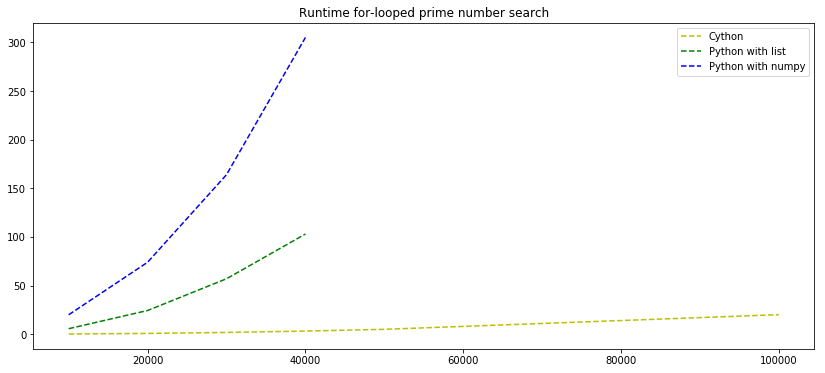

In [32]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14, 6)

# plot the result
x = [1e4, 2e4, 3e4, 4e4, 5e4, 10e4]
cython = [0.26, 0.81, 1.86, 3.23, 5.04, 20.1]
py_list =[5.69, 24.4, 57, 60+43, None, None]
py_npy = [20, 60+14, 120+44, 5*60 + 5, None, None]

plt.plot(x, cython, 'y--', label='Cython')
plt.plot(x, py_list, 'g--', label='Python with list')
plt.plot(x, py_npy, 'b--', label='Python with numpy')
plt.title('Runtime for-looped prime number search')
plt.legend()

### 3. Heavy load

The results show the same dependencies between the time to compute n prime numbers like the second task.
Only the Cython test was held out until the end because the others just would not come to an end without implying the need to log scale the time axis in the previous chart.

As a conclusion it is obvious that the Cython code outperforms the others by a large factor. 

(Note: I know that there are better prime checks and speed ups for this. The coded is only intented to use a lot of for-loops not to be efficient.)

## Compiling the cython code

In this section I am going to cover how to compile cython code for the use in a code base. 

- [Cython tutorial](http://cython.readthedocs.io/en/latest/src/tutorial/cython_tutorial.html)
- [Cython numpy tutorial](http://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html)


1. Create a .pyx file containing the cython code
2. Configure your setup.py to be able to cythonize, build, link and compile
3. Import the cython module in python and call it

```python
# primes.pyx

import numpy as np
cimport numpy as np

def get_primes_cython(int n):
    cdef:
        np.ndarray[np.int32_t, ndim=1] primes = np.zeros(n, dtype=np.int32)
        int i = 0;
        int last_prime = 2;
        int candidate = 1;
        int is_ok = 1;
    
    while (i<n):
        candidate += 1;
        is_ok = 1;
        
        for c in range(i):
            if candidate % primes[c] == 0:
                is_ok = 0;
                break;

        if is_ok == 1:
            primes[i] = candidate;
            i += 1;
    
    return primes
```

```python
# setup.pyx

from distutils.core import setup
from distutils.extension import Extension
from Cython.Distutils import build_ext
import numpy as np

ext_modules = [Extension("primes", ["primes.pyx"])]

setup(
  name = 'Primes app',
  cmdclass = {'build_ext': build_ext},
  include_dirs = [np.get_include()],
  ext_modules = ext_modules
)
```

**3,2,1... Compile:**

`python setup.py build_ext --inplace`

`ls -la`

```
drwxrwxr-x 4 daniel daniel   4096 Jun 25 06:14 .
drwxrwxr-x 4 daniel daniel   4096 Jun 21 20:33 ..
drwxrwxr-x 3 daniel daniel   4096 Jun 25 06:13 build
-rw-rw-r-- 1 daniel daniel  48488 Jun 25 06:08 cython.ipynb
drwxrwxr-x 2 daniel daniel   4096 Jun 21 20:34 .ipynb_checkpoints
-rw-rw-r-- 1 daniel daniel 276774 Jun 25 06:14 primes.c
-rwxrwxr-x 1 daniel daniel 113696 Jun 25 06:14 primes.cpython-35m-x86_64-linux-gnu.so
-rw-rw-r-- 1 daniel daniel    563 Jun 25 06:14 primes.pyx
-rw-rw-r-- 1 daniel daniel    336 Jun 25 06:14 setup.py
```
    

# Let's call the prime code

The cool thing is that we can import the code and run the methods defined in the .pyx file.


```python
Python 3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609] on linux
Type "help", "copyright", "credits" or "license" for more information.
>>> import primes
>>> primes.get_primes_cython(10000)
array([     2,      3,      5, ..., 104717, 104723, 104729], dtype=int32)
```